<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/29.00-Modelo_Individual_forca_de_infeccao.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelo individual: fase de contágio](28.00-Modelo_Individual_fase_de_contagio.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# Modelo individual: força de infecção

- Vamos analisar com mais cuidado a força de infecção

- Em particular, o termo de modulação $\kappa(T; \delta, \eta)$.

In [1]:
import datetime as dt # date and time tools

from os import path

import random

import numpy as np
from scipy.stats import lognorm

import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

from PIL import Image as PIL_Image

In [2]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 22/Jun/2020


In [3]:
sns.set_style("darkgrid")

## Termo de modulação

- Lembramos que a força de infecção, agindo em cada suscetível, por um determinado infectado, em uma rede de completa de $n$ indivíduos é

$$ \lambda = \frac{\beta}{n} \kappa(T;\delta, \eta),
$$

- É assumido que $\kappa(T; \delta, \eta)$ é uma log-normal em $T$, com $\delta$ e $\eta$ sendo a média e o desvio padrão de $\ln T$.

- Porém, como $T$ tem unidade de tempo, o termo $\kappa$ fica com unidade inversa $1/\textrm{tempo}$, fazendo com que $\lambda$ seja adimensional e $\lambda \Delta t$ tenha dimensão de tempo. Porém, tanto $\lambda \Delta t$, quanto $\int \lambda dt$ devem ser adimensionais.

- Uma proposta é introruzir um novo parâmetro $\zeta$ com dimensão $1/\textrm{tempo}$ e considerar

$$ \kappa(T; \zeta, \delta, \eta) = \frac{1}{\zeta}\textrm{log-normal} = \frac{1}{\zeta\eta T\sqrt{2\pi}} e^{\displaystyle -\frac{\ln^2(e^{-\delta} T)}{2\eta^2}}, \qquad T\geq 0.
$$

## Dados e ajuste para perfil de força de infecção da Figura SI8

- Inspirado pelo que foi feito nas notas anteriores, vamos fazer o que deveríamos ter feito de início.

- Os parâmetros em [Ferguson et al (2005)](#Referências) e [Ferguson et al (2006)](#Referências) são ilustrados na [Figura SI8 do material suplementar de Ferguson et al (2006)](#Referências) ao longo de supostos dados clínicos.

- Não encontramos os dados no artigo citado na figura, mas podemos fazer o mesmo procedimento com a Figura SI8 para extrair os dados:

    - Capturar a figura do artigo em um arquivo de imagem tipo `png` ou outro.
    
    - Exibir a imagem em uma figura do `pyplot`
    
    - Sobrepor pontos, com as devidas coordenadas ajustadas manualmente, para que coincidam com os pontos da imagem.
    
    - Usar marcadores para acertar a escala.
    
    - Transformar os dados para a escala desejada.

### Carregando a figura

(1934, 1324)


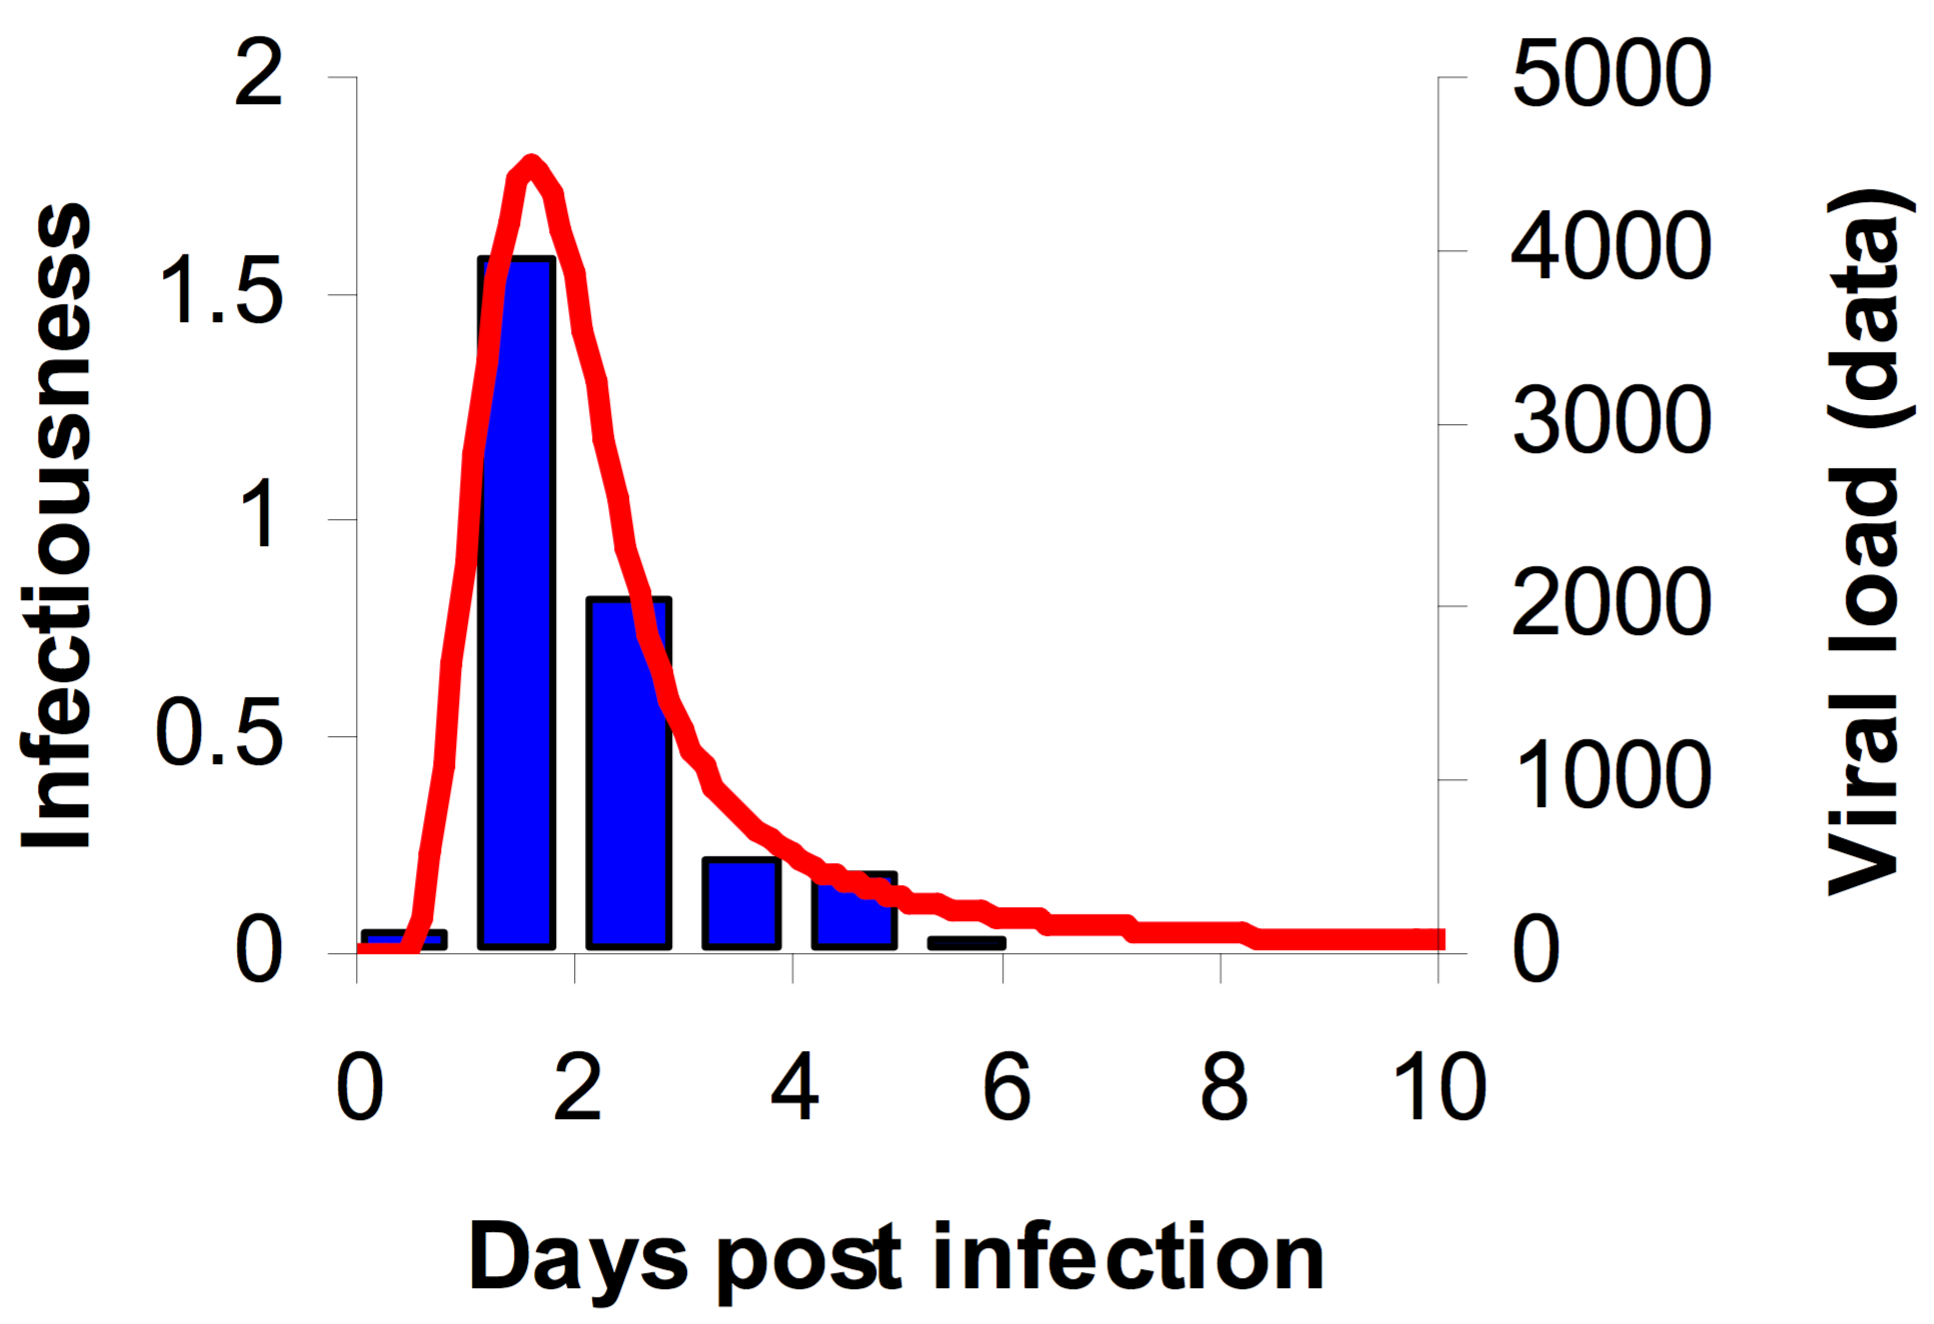

In [4]:
FergusonSI8b = PIL_Image.open(path.join('..', 'input', 'modelos_individuais', 'FergusonDaysPostInfection2006.png'))
print(FergusonSI8b.size)
FergusonSI8b

### Sobrepondo pontos para obtenção dos dados

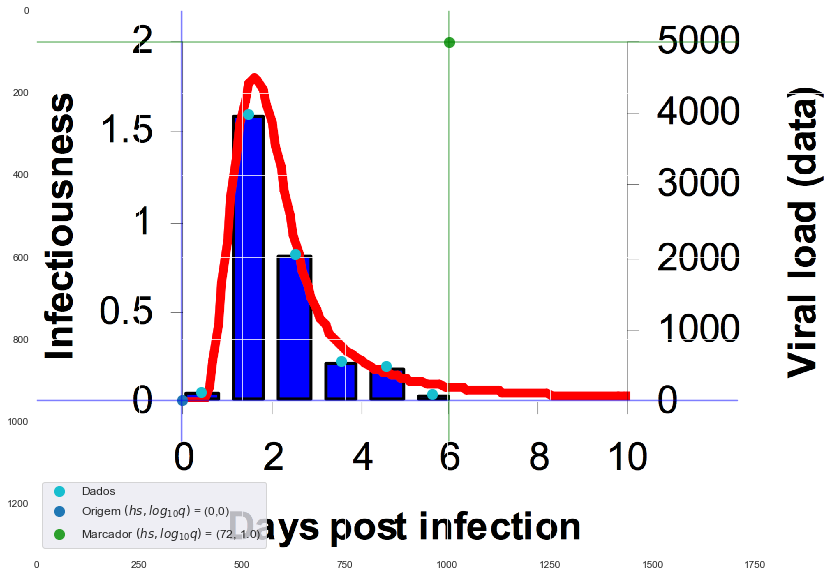

In [5]:
plt.figure(figsize=(15,10))
plt.imshow(FergusonSI8b)
x_pts = np.arange(0, 1708)
y_pts = np.arange(0, 1050)
x_org, y_org = 353, 950
x_mar, y_mar = 1004, 77
fig_x = np.array([400, 514, 630, 742, 850, 962])
fig_y = np.array([930, 252, 594, 854, 866, 934])
plt.plot(fig_x, fig_y, 'o', color='tab:cyan', markersize=10, label='Dados')
plt.plot(x_org, y_org, 'o', color='tab:blue', markersize=10, label='Origem $(hs, log_{10}q)$ = (0,0)')
plt.plot(x_mar, y_mar, 'o', color='tab:green', markersize=10, label='Marcador $(hs, log_{10}q)$ = (72, 1.0)')
plt.plot(x_pts, y_org*np.ones_like(x_pts), 'b-', alpha=0.5)
plt.plot(x_org*np.ones_like(y_pts), y_pts, 'b-', alpha=0.5)
plt.plot(x_pts, y_mar*np.ones_like(x_pts), 'g-', alpha=0.5)
plt.plot(x_mar*np.ones_like(y_pts), y_pts, 'g-', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

### Ajustando os dados para as coordenadas da figura

- Os dados acima foram ajustados pelas coordenadas dos pontos.

- Vamos transformá-las para os valores da figura.

- Observe que o ponto $(0,0)$ da imagem corresponde aproximadamente a `(x_org, y_org) = (353, 950)` e o marcador $(6, 2)$ corresponde a `(x_mar, y_mar) = (1004, 77)`.

- Usando esses valores e sabendo que os dois eixos estão em escala linear, fazemos a transformação dos pontos $(x_\textrm{pts}, y_\textrm{pts})$ em $(x,y)$ de acordo com:

$$ x = 6\frac{x_\textrm{pts} - x_\textrm{org}}{x_\textrm{mar} - x_\textrm{org}}, \qquad y_\textrm{log} = 2\frac{y_\textrm{pts} - y_\textrm{org}}{y_\textrm{mar} - y_\textrm{org}}
$$

In [6]:
x = 6*(fig_x - x_org)/(x_mar - x_org)
y = 2*(fig_y - y_org)/(y_mar - y_org)

### Exibindo os dados extraídos da figura e a log-normal com parâmetros do artigo

- Usando os valores médios $\delta = -0.72$ e $\eta = 1.8$ dos parâmetros mencionados no artigo para definir a log-normal, traçamos o gráfico da PDF em conjunto com os dados obtidos da Figura.

In [7]:
T_int = np.linspace(0, 10, 200)
delta = -0.72
eta = 1.8
kappa = lognorm.pdf(T_int, s=eta, scale=np.exp(delta))

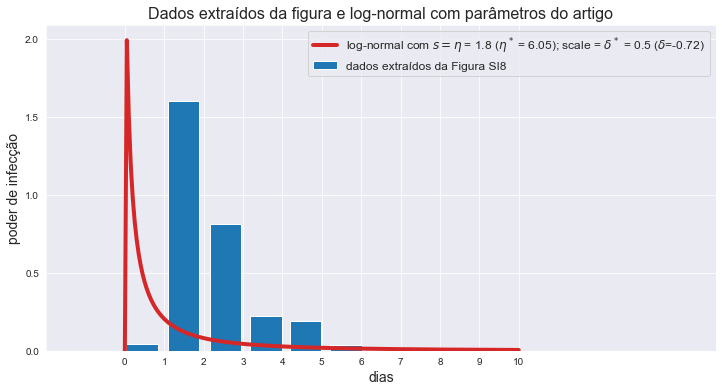

In [8]:
plt.figure(figsize=(12,6))
plt.bar(x, y, color='tab:blue', label='dados extraídos da Figura SI8')
plt.plot(T_int, kappa, color='tab:red', linewidth=4,
         label=f'log-normal com $s = \eta$ = {eta} ($\eta^*$ = {np.exp(eta):.2f}); '
         + f'scale = $\delta^*$ = {np.exp(delta):.1f} ($\delta$={delta})')
plt.xticks(list(range(11)))
plt.yticks([0.5*j for j in range(5)])
plt.xlim([-2, 15])
plt.ylabel('poder de infecção', fontsize=14)
plt.xlabel('dias', fontsize=14)
plt.legend(fontsize=12)
plt.title('Dados extraídos da figura e log-normal com parâmetros do artigo',
          fontsize=16)
plt.show()

### Log-normal com outros parâmetros

- Observe que a log-normal obtida acima ficou bem longe da log-normal do artigo.

- Fazendo ajustes, obtemos novos parâmetros mais apropriados.

- Um primeiro ajuste é incluir um deslocamento de 0.2, obtido na função `scipy.stats.lognorm.pdf` com o argumento `loc=0.2`.

- Outro ajuste é multiplicarmos a pdf por um fator de ajuste para alcançarmos os valores da escala apropriada.

- Mas o ajuste mais significativo vem de trocar os papéis de $e^\delta$ e $\eta$ na aplicação de [scipy.stats.lognorm.pdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)!

- Na definição do artigo, $\delta=-0.72$ é a média (e mediana) de $\log T$, de forma que $\delta^*=e^\delta$ é a mediana de $T$. Esse valor de $e^\delta$ entra na `lognorm` como o argumento `scale`.

- Ainda no artigo, $\eta=1.8$ é o desvio padrão de $\log T$. Isso entra como argumento `s` de `lognorm`.

- Mas vimos acima que `s=eta` e `scale=np.exp(delta)` nos dão um perfil muito distante dos dados.

- Porém, ao invertermos esses papéis, o resultado fica bem melhor:

In [9]:
loc = 0.2
fator = 3.5
kappa = fator*lognorm.pdf(T_int, s=np.exp(delta), scale=eta, loc=loc)

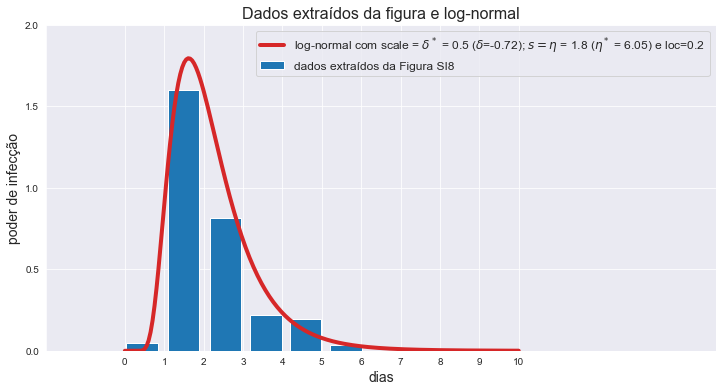

In [10]:
plt.figure(figsize=(12,6))
plt.bar(x, y, color='tab:blue', label='dados extraídos da Figura SI8')
plt.plot(T_int, kappa, color='tab:red', linewidth=4,
         label=f'log-normal com scale = $\delta^*$ = {np.exp(delta):.1f} ($\delta$={delta}); '
         + f'$s = \eta$ = {eta} ($\eta^*$ = {np.exp(eta):.2f}) e loc={loc}')
plt.xticks(list(range(11)))
plt.yticks([0.5*j for j in range(5)])
plt.xlim([-2, 15])
plt.ylabel('poder de infecção', fontsize=14)
plt.xlabel('dias', fontsize=14)
plt.legend(fontsize=12)
plt.title('Dados extraídos da figura e log-normal', fontsize=16)
plt.show()

### Comparações com outros parâmetros

- Coincidência ou não, conseguimos uma aproximação boa substituindo o fator 3.5 por uma combinação dos parâmetros $\delta^*$ e $\eta^*$, em que

$$  \textrm{fator} = \delta^*\eta^* = e^\eta e^\delta \approx 2.95.
$$

- Observe, ainda, que, sendo $\eta$ adimensional e $\delta^* = e^{\delta}$ com dimensão de tempo, temos que o fator acima tem dimensão de tempo, fazendo com que

$$ \kappa(T; \zeta, \delta, \eta) = \frac{1}{\zeta\eta T\sqrt{2\pi}} e^{\displaystyle -\frac{\ln^2(e^{-\delta} T)}{2\eta^2}},
$$

com $1/\zeta =  \delta^*\eta^*$, seja adimensional, como desejamos.

- Abaixo fazemos essa e outras comparações.

In [11]:
delta = -0.72
eta = 1.8
fator = 3.5
zeta_inv = np.exp(delta)*np.exp(eta)
loc = 0.2
loc2 = 0.6
kappa_artigo_puro = lognorm.pdf(T_int, s=eta, scale=np.exp(delta))
kappa_artigo_loc = lognorm.pdf(T_int, s=eta, scale=np.exp(delta), loc=loc2)
kappa_trocado_fator = fator*lognorm.pdf(T_int, s=np.exp(delta), scale=eta)
kappa_trocado_fator_loc = fator*lognorm.pdf(T_int, s=np.exp(delta), scale=eta, loc=loc)
kappa_trocado_fator_param = zeta_inv * lognorm.pdf(T_int, s=np.exp(delta), scale=eta)
kappa_trocado_fator_param_loc = zeta_inv * lognorm.pdf(T_int, s=np.exp(delta), scale=eta, loc=loc)

#### Comparando com fator dado pelos parâmetros

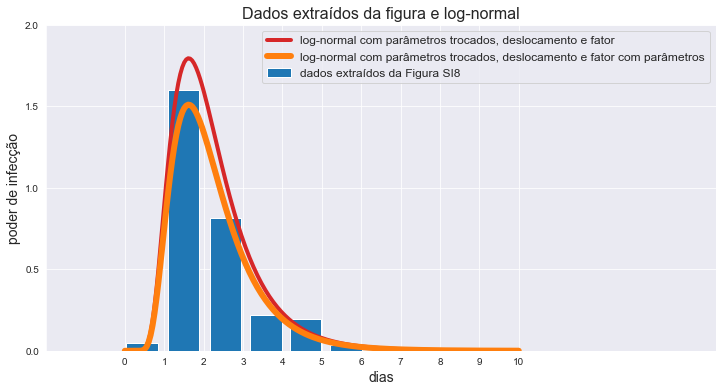

In [12]:
plt.figure(figsize=(12,6))
plt.bar(x, y, color='tab:blue', label='dados extraídos da Figura SI8')
plt.plot(T_int, kappa_trocado_fator_loc, color='tab:red', linewidth=4,
         label=f'log-normal com parâmetros trocados, deslocamento e fator')
plt.plot(T_int, kappa_trocado_fator_param_loc, color='tab:orange', linewidth=6,
         label=f'log-normal com parâmetros trocados, deslocamento e fator com parâmetros')
plt.xticks(list(range(11)))
plt.yticks([0.5*j for j in range(5)])
plt.xlim([-2, 15])
plt.ylabel('poder de infecção', fontsize=14)
plt.xlabel('dias', fontsize=14)
plt.legend(fontsize=12)
plt.title('Dados extraídos da figura e log-normal', fontsize=16)
plt.show()

#### Comparando com fator dado pelos parâmetros e com ou sem deslocamento

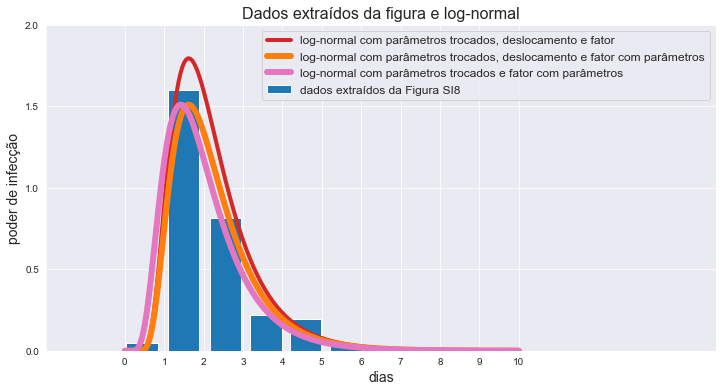

In [13]:
plt.figure(figsize=(12,6))
plt.bar(x, y, color='tab:blue', label='dados extraídos da Figura SI8')
plt.plot(T_int, kappa_trocado_fator_loc, color='tab:red', linewidth=4,
         label=f'log-normal com parâmetros trocados, deslocamento e fator')
plt.plot(T_int, kappa_trocado_fator_param_loc, color='tab:orange', linewidth=6,
         label=f'log-normal com parâmetros trocados, deslocamento e fator com parâmetros')
plt.plot(T_int, kappa_trocado_fator_param, color='tab:pink', linewidth=6,
         label=f'log-normal com parâmetros trocados e fator com parâmetros')
plt.xticks(list(range(11)))
plt.yticks([0.5*j for j in range(5)])
plt.xlim([-2, 15])
plt.ylabel('poder de infecção', fontsize=14)
plt.xlabel('dias', fontsize=14)
plt.legend(fontsize=12)
plt.title('Dados extraídos da figura e log-normal', fontsize=16)
plt.show()

#### Todas as comparações consideradas

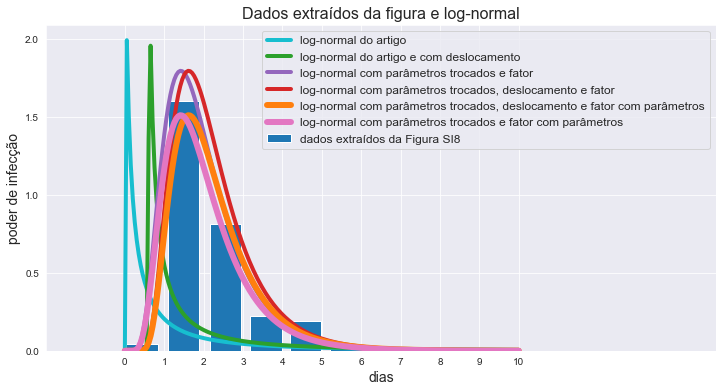

In [14]:
plt.figure(figsize=(12,6))
plt.bar(x, y, color='tab:blue', label='dados extraídos da Figura SI8')
plt.plot(T_int, kappa_artigo_puro, color='tab:cyan', linewidth=4,
         label=f'log-normal do artigo')
plt.plot(T_int, kappa_artigo_loc, color='tab:green', linewidth=4,
         label=f'log-normal do artigo e com deslocamento')
plt.plot(T_int, kappa_trocado_fator, color='tab:purple', linewidth=4,
         label=f'log-normal com parâmetros trocados e fator')
plt.plot(T_int, kappa_trocado_fator_loc, color='tab:red', linewidth=4,
         label=f'log-normal com parâmetros trocados, deslocamento e fator')
plt.plot(T_int, kappa_trocado_fator_param_loc, color='tab:orange', linewidth=6,
         label=f'log-normal com parâmetros trocados, deslocamento e fator com parâmetros')
plt.plot(T_int, kappa_trocado_fator_param, color='tab:pink', linewidth=6,
         label=f'log-normal com parâmetros trocados e fator com parâmetros')
plt.xticks(list(range(11)))
plt.yticks([0.5*j for j in range(5)])
plt.xlim([-2, 15])
plt.ylabel('poder de infecção', fontsize=14)
plt.xlabel('dias', fontsize=14)
plt.legend(fontsize=12)
plt.title('Dados extraídos da figura e log-normal', fontsize=16)
plt.show()

### Parâmetros obtidos com a troca

- Ao consideramos a troca entre $\eta$ e $e^\delta$, vamos denotar os valores "antigos" de $\tilde\delta = -0.72$ e $\tilde\eta = 1.8$.

- Assim, conseguirmos os seguintes "novos" (ou "corretos"?) parâmetros para a log-normal:

    - A nova média de $\ln T$ é $\delta = \ln \tilde\eta = \ln 1.8 \approx 0.588$
    
    - O novo desvio padrão de $\ln T$ é $\eta = e^{\tilde\delta} = e^{-0.72} \approx 0.487$

### Parâmetros derivados da troca

- Com esses valores, e desconsiderando o deslocamento de 0,2 dias, obtemos os seguintes parâmetros sobre o tempo de contágio:

    - A mediana do tempo de contágio é $e^{\delta} = \tilde\eta = 1.8$ dias.
    
    - A média do tempo de contágio é $e^{\delta + \eta^2/2} = \eta e^{e^{- 2 \times 0.72}/2} \approx 2.03$ dias.
    
    - Tempo para 84,2% dos contágios é de aproximadamente $e^\delta e^\eta \approx 2,93$ dias. 
    
    - Tempo para 97,7% dos contágios é de aproximadamente $e^\delta e^{2\eta} \approx 4,76$ dias.
    
    - Tempo para 99% dos contágios é $e^ \delta e^{2.33\eta} \approx 5,6$ dias.
    
    - Tempo para 99,865% dos contágios é $e^\delta e^{3\eta} \approx 7,75$ dias.

- Perfeitamente razoáveis!

- E observe que conhecendo duas das quantidades acima, podemos definir as outras, em particular $\delta$ e $\eta$.

In [15]:
delta = -0.72
eta = 1.8
delta_prime = np.log(eta)
eta_prime = np.exp(delta)
print()
print(f'Média de ln(T): {delta_prime:.3f}')
print(f'Desvio padrão de ln(T): {eta_prime:.3f}')
print()
print(f'Mediana do tempo de contágio: {eta:.1f}')
print(f'Media do tempo de contágio: {np.exp(delta_prime + eta_prime**2/2):.2f}')
print()
print(f'Tempo para 84.2% dos contágios: {np.exp(delta_prime)*np.exp(eta_prime):.2f}')
print(f'Tempo para 97,7% dos contágios: {np.exp(delta_prime)*np.exp(eta_prime)**2:.2f}')
print(f'Tempo para 99% dos contágios: {np.exp(delta_prime)*np.exp(eta_prime)**2.33:.2f}')
print(f'Tempo para 99.865% dos contágios: {np.exp(delta_prime)*np.exp(eta_prime)**3:.2f}')


Média de ln(T): 0.588
Desvio padrão de ln(T): 0.487

Mediana do tempo de contágio: 1.8
Media do tempo de contágio: 2.03

Tempo para 84.2% dos contágios: 2.93
Tempo para 97,7% dos contágios: 4.76
Tempo para 99% dos contágios: 5.60
Tempo para 99.865% dos contágios: 7.75


### Percentis

- Abaixo, mais percentis.

- Para simplificar, vamos mostrar os percentis da normal com média $\mu$ e desvio-padrão $\sigma$, que são traduzidos para a log-normal tomando-se a exponencial.

    - 84,2%: integral em $(-\infty, \mu + \sigma)$;
    
    - 97,5%: integral em $(-\infty, \mu + 1.96\sigma)$;
    
    - 97,7%: integral em $(-\infty, \mu + 2\sigma)$;
 
    - 99%: integral em $(-\infty, \mu + 2.33\sigma)$;
    
    - 99.85%: integral em $(-\infty, \mu + 2.97\sigma)$;
    
    - 99.865%: integral em $(-\infty, \mu + 3\sigma)$.

- Para os percentis da log-normal, o limite inferior da integral é $0$ e o limite superior é dado por $\mu^*{\sigma^*}^q$, onde $q$ é a fator multiplicativo de cada $\sigma$ acima.

### Parâmetros para covid-19

- É fundamental termos dados da Covid-19 para deduzirmos os parâmetros apropriados.

- Para isso, podemeos buscar mais informações nos seguintes artigos:

    - [Long et al (2020)](#Referências)
    
    - [Jeroen et al (2020)](#Referências) (Especialmente a Figura 2!)
    
    - [Qi et al (2020)](#Referências)

    - [ECDC (2020) - Discharge Criteria](#Referências)
    
    - [ECDC (2020) - Transmission of COVID-19](#Referências)

## Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020. (Free Download)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [ECDC (2020), Transmission of COVID-19](https://www.ecdc.europa.eu/en/covid-19/latest-evidence/transmission)

- [ECDC (2020), Novel coronavirus (SARS-CoV-2) Discharge criteria for confirmed COVID-19 cases -  When is it safe to discharge COVID-19 cases from the hospital or end home isolation?](https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-Discharge-criteria.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2).

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).

- [Hayden et al (1999), Use of the oral neuraminidase inhibitor Oseltamivir in experimental human influenza, JAMA, Vol 282, no. 13, 1240--1246](https://jamanetwork.com/journals/jama/fullarticle/191957).

- [Jeroen J.A et al (2020), Shedding of infectious virus in hospitalized patients with coronavirus disease-2019 (COVID- 19): duration and key determinants](https://www.medrxiv.org/content/10.1101/2020.06.08.20125310v1)

- [Lauer SA, Grantz KH, Bi Q, Jones FK, Zheng Q, Meredith HR, Azman AS, Reich NG, Lessler J (2020), The incubation period of coronavirus disease 2019 (COVID-19) from
publicly reported confirmed cases: estimation and application, Ann Intern Med. M20-0504](https://dx.doi.org/10.7326%2FM20-0504)

- [Long, Q., Tang, X., Shi, Q. et al (2020). Clinical and immunological assessment of asymptomatic SARS-CoV-2 infections. Nat Med](https://doi.org/10.1038/s41591-020-0965-6)

- [Pellis L, Ball F, Trapman P. (2012), Reproduction numbers for epidemic models with households and other social structures. I. Definition and calculation of R_0, Mathe. Biosciences 235, 85--97](https://doi.org/10.1016/j.mbs.2011.10.009).

- [Qi L et al (2020), Factors associated with the duration of viral shedding in adults with COVID-19 outside of Wuhan, China: a retrospective cohort study, International Journal of Infectious Diseases 96, 531–537](https://www.ijidonline.com/article/S1201-9712(20)30352-0/pdf)

- [A. Svensson (2007), A note on generation times in epidemic models, Math. Biosciences, Volume 208, Issue 1, 300--311](https://doi.org/10.1016/j.mbs.2006.10.010).

<!--NAVIGATOR-->

---
[<- Modelo individual: fase de contágio](28.00-Modelo_Individual_fase_de_contagio.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 